# Using dGPS on GLE to Validate the Fusion Strategy

In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl

ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))

SHOW_FIGS = False

## Read the GLE Data


In [2]:
# Length of the GLE

GLE_m = 4.93522
DIST_2_FRONT_m = 2.91
DIST_2_BACK_m = 1.99


veh_df = (
    pl.read_csv(
        ROOT / "data" / "vehicle_drives" / "2023-10-31.csv",
    )
    .drop("")
    .with_columns(
        pl.col("gps_time").str.strptime(
            dtype=pl.Datetime(
                time_unit="us",
            ),
        ),
    )
    .sort(
        "gps_time",
    )
    .with_row_count(name="seq")
)

## Create the Network


In [3]:
import geopandas as gpd
from src.geometry import RoadNetwork


network = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    step_size=0.01,
)

lane_df = network.df

LANE_WIDTH = 3.5

## Snap the Vehicle Trajectories to Lanes


In [4]:
import utm

x, y, _, _ = utm.from_latlon(
    latitude=veh_df["lat"].to_numpy(),
    longitude=veh_df["lon"].to_numpy(),
)

GLE_m = 4.93522
DIST_2_FRONT_m = 2.91
DIST_2_BACK_m = 1.99


veh_df = (
    veh_df.sort("gps_time")
    .with_columns(
        x=x,
        y=y,
        gps_time=pl.col("gps_time").dt.truncate("100ms"),
    )
    .with_columns(
        pl.col("x").diff().alias("dx"),
        pl.col("y").diff().alias("dy"),
    )
    .with_columns(
        (pl.col("dx").pow(2) + pl.col("dy").pow(2)).sqrt().alias("dist"),
        # find the heading
        pl.arctan2(pl.col("dy"), pl.col("dx")).alias("heading"),
    )
    .with_columns(
        pl.col("dist").cum_sum().alias("cum_dist"),
        # make the front x/y position
        (pl.col("x") + (DIST_2_FRONT_m * pl.col("heading").cos())).alias("front_x"),
        (pl.col("y") + (DIST_2_FRONT_m * pl.col("heading").sin())).alias("front_y"),
        (pl.col("x") - (DIST_2_BACK_m * pl.col("heading").cos())).alias("back_x"),
        (pl.col("y") - (DIST_2_BACK_m * pl.col("heading").sin())).alias("back_y"),
    )
    .with_columns(
        #
        (
            (pl.col("cum_dist").shift(-1) - pl.col("cum_dist").shift(1)).abs()
            / (
                (
                    pl.col("gps_time").shift(-1) - pl.col("gps_time").shift(1)
                ).dt.total_milliseconds()
                / 1e3
            )
        ).alias("speed"),
    )
    .pipe(
        network.map_to_lane,
        dist_upper_bound=LANE_WIDTH,
        utm_x_col="x",
        utm_y_col="y",
    )
    .filter(
        pl.col("name").is_not_null()
        & (pl.col("s") > 150)
        & (pl.col("s") < (pl.col("s").max() - 150)).over("name")
    )
    .rename(
        {
            "name": "lane",
            "angle": "heading_lane",
        }
    )
    .with_columns((pl.col("heading") - pl.col("heading_lane")).alias("angle_diff"))
    .with_columns(
        # find the portion of velocity that is in the direction of the lane
        pl.arctan2(pl.col("angle_diff").sin(), pl.col("angle_diff").cos()).alias(
            "angle_diff"
        )
    )
    .with_columns(
        (pl.col("speed") * pl.col("angle_diff").cos()).alias("s_velocity"),
        (pl.col("speed") * pl.col("angle_diff").sin()).alias("d_velocity"),
        ((DIST_2_FRONT_m * pl.col("angle_diff").cos()) + pl.col("s")).alias("front_s"),
        (pl.col("s") - (DIST_2_BACK_m * pl.col("angle_diff").cos())).alias("back_s"),
        # do the vehicle length
        (GLE_m * pl.col("angle_diff").cos()).alias("length_s"),
    )
)

veh_df.head()

shape: (5, 30)
┌──────┬────────────┬───────────┬────────────┬───┬────────────┬────────────┬────────────┬──────────┐
│ seq  ┆ gps_time   ┆ lat       ┆ lon        ┆ … ┆ d_velocity ┆ front_s    ┆ back_s     ┆ length_s │
│ ---  ┆ ---        ┆ ---       ┆ ---        ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---      │
│ u32  ┆ datetime[μ ┆ f64       ┆ f64        ┆   ┆ f64        ┆ f64        ┆ f64        ┆ f64      │
│      ┆ s, UTC]    ┆           ┆            ┆   ┆            ┆            ┆            ┆          │
╞══════╪════════════╪═══════════╪════════════╪═══╪════════════╪════════════╪════════════╪══════════╡
│ 1318 ┆ 2023-10-31 ┆ 33.235664 ┆ -87.610399 ┆ … ┆ 6.84203    ┆ 1236.50667 ┆ 1235.31292 ┆ 1.202335 │
│      ┆ 16:45:34.5 ┆           ┆            ┆   ┆            ┆ 6          ┆ 1          ┆          │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆            ┆          │
│ 1319 ┆ 2023-10-31 ┆ 33.235671 ┆ -87.610399 ┆ … ┆ 6.936736   ┆ 1236.72666 ┆ 1235.46557 ┆ 1.270158 │
│      ┆ 16:45:34.6 ┆           ┆            ┆   ┆            ┆ 7          ┆ 3          ┆          │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆            ┆          │
│ 1320 ┆ 2023-10-31 ┆ 33.235677 ┆ -87.6104   ┆ … ┆ 7.028601   ┆ 1236.85753 ┆ 1235.67917 ┆ 1.186838 │
│      ┆ 16:45:34.7 ┆           ┆            ┆   ┆            ┆ 7          ┆            ┆          │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆            ┆          │
│ 1321 ┆ 2023-10-31 ┆ 33.235684 ┆ -87.6104   ┆ … ┆ 7.139042   ┆ 1237.03171 ┆ 1235.84631 ┆ 1.193918 │
│      ┆ 16:45:34.8 ┆           ┆            ┆   ┆            ┆ 2          ┆ 4          ┆          │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆            ┆          │
│ 1322 ┆ 2023-10-31 ┆ 33.235691 ┆ -87.6104   ┆ … ┆ 7.270159   ┆ 1237.20673 ┆ 1236.02971 ┆ 1.185475 │
│      ┆ 16:45:34.9 ┆           ┆            ┆   ┆            ┆ 3          ┆ 8          ┆          │
│      ┆ 00 UTC     ┆           ┆            ┆   ┆            ┆            ┆            ┆          │
└──────┴────────────┴───────────┴────────────┴───┴────────────┴────────────┴────────────┴──────────┘

## Read in the Radar Trajectories 

Both the prcessed and unprocessed.

### Raw Radar Data

In [5]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df
from src.pipelines.association import add_front_back_s
from src.pipelines.kalman_filter import prepare_frenet_measurement


radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "march_calibrated.yaml",
)


raw_radar_df = (
    pl.scan_parquet(
        Path(os.environ.get("RAW_DATA_DIR")).joinpath("*.parquet"),
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .with_context(veh_df.lazy())
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("gps_time").min() - timedelta(minutes=1),
            pl.col("gps_time").max() + timedelta(minutes=1),
        )
    )
    .collect()
    .lazy()
    .pipe(prep_df, f=radar_obj)
    .pipe(
        network.map_to_lane,
        dist_upper_bound=8,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .with_columns(
        back_x=(
            (pl.col("heading_utm").cos() * pl.col("f32_distanceToBack_m"))
            + pl.col("utm_x")
        ),
        back_y=(
            (pl.col("heading_utm").sin() * pl.col("f32_distanceToBack_m"))
            + pl.col("utm_y")
        ),
        front_x=(
            (pl.col("heading_utm").cos() * pl.col("f32_distanceToFront_m"))
            + pl.col("utm_x")
        ),
        front_y=(
            (pl.col("heading_utm").sin() * pl.col("f32_distanceToFront_m"))
            + pl.col("utm_y")
        ),
    )
    .rename(
        {
            "name": "lane",
            "angle": "heading_lane",
        }
    )
    .pipe(prepare_frenet_measurement)
    .pipe(add_front_back_s, use_median_length=False)
    .collect()
)

/home/max/Development/roadside-radar/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


function: create_object_id took: 0.0002391338348388672 seconds
function: filter_short_trajectories took: 0.0003731250762939453 seconds
function: clip_trajectory_end took: 0.00021076202392578125 seconds
function: resample took: 0.00020956993103027344 seconds
function: fix_duplicate_positions took: 0.0002353191375732422 seconds
function: set_timezone took: 4.076957702636719e-05 seconds
function: add_cst_timezone took: 2.5510787963867188e-05 seconds
function: add_heading took: 2.86102294921875e-05 seconds
function: rotate_radars took: 0.00046324729919433594 seconds
function: update_origin took: 0.00036334991455078125 seconds
function: prepare_frenet_measurement took: 0.0006229877471923828 seconds
function: add_front_back_s took: 0.00019550323486328125 seconds


### Read in the Processed Radar Data

In [24]:
processed_radar_df = pl.read_parquet(
    ROOT / "data" / "merged_october.parquet",
)

processed_radar_df.head()

shape: (5, 32)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_inde ┆ ci_front_ ┆ ci_s_velo ┆ ci_s_acce ┆ … ┆ ci_front_ ┆ ci_front_ ┆ ci_back_x ┆ ci_back_ │
│ x         ┆ s         ┆ city      ┆ l         ┆   ┆ x         ┆ y         ┆ ---       ┆ y        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ ---      │
│ u32       ┆ f64       ┆ f32       ┆ f32       ┆   ┆ f64       ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 784       ┆ -8944.616 ┆ -4023.046 ┆ -0.002684 ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│           ┆ 211       ┆ 143       ┆           ┆   ┆           ┆           ┆           ┆          │
│ 790       ┆ -7731.891 ┆ -5127.239 ┆ 6.7854e-7 ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│           ┆ 113       ┆ 258       ┆           ┆   ┆           ┆           ┆           ┆          │
│ 791       ┆ -7715.800 ┆ -4924.436 ┆ 6.9182e-7 ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│           ┆ 781       ┆ 523       ┆           ┆   ┆           ┆           ┆           ┆          │
│ 789       ┆ -7697.963 ┆ -5322.824 ┆ 6.6577e-7 ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│           ┆ 379       ┆ 219       ┆           ┆   ┆           ┆           ┆           ┆          │
│ 792       ┆ -7654.082 ┆ -4716.764 ┆ 7.0561e-7 ┆ … ┆ null      ┆ null      ┆ null      ┆ null     │
│           ┆ 031       ┆ 16        ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

#### Remove any Bad Matches in the Association

In [25]:
processed_radar_df["vehicle_id"].n_unique()

16284

In [31]:
chi.ppf(0.9999, 4)

4.848993962152466

array([[<Axes: title={'center': 'association_distance'}>]], dtype=object)

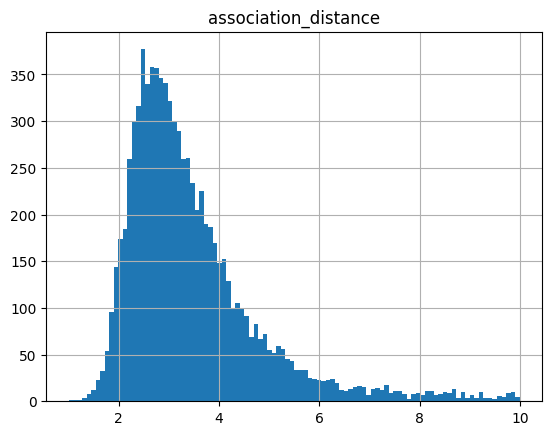

In [29]:
processed_radar_df.group_by("vehicle_id").agg(
    pl.col("association_distance").max()
).filter(pl.col("association_distance") < 10)[
    ["association_distance"]
].to_pandas().hist(
    bins=100
)

In [32]:
from scipy.stats import chi

processed_radar_df = processed_radar_df.filter(
    pl.col("association_distance")
    .filter(pl.col("association_distance").is_not_null())
    .quantile(0.75)
    .over("vehicle_id")
    < chi.ppf(0.9999, 4)
)

In [33]:
processed_radar_df["vehicle_id"].n_unique()

8214

In [34]:
crop_s = processed_radar_df.group_by(["lane", "lane_index"]).agg(
    pl.col("ci_front_s").quantile(0.05).alias("quanitile_5"),
    pl.col("ci_front_s").quantile(0.95).alias("quanitile_95"),
)

### Read in the Imtermediate IMM Filtered Data

In [35]:
imm_filter_df = (
    pl.scan_parquet(
        ROOT / "data" / "october_kalman.parquet",
    )
    .filter(~pl.col("prediction"))
    .collect()
)

## Calculate the Optimal Time Offset b/ Radar and GPS

In [36]:
veh_df = (
    veh_df.with_columns(
        pl.col("lane").fill_null(""),
    )
    .with_columns(
        (
            (pl.col("gps_time").diff().dt.total_seconds() > 10)
            | (pl.col("lane").shift(1) != pl.col("lane"))
        ).alias("sequence"),
    )
    .with_columns(
        (pl.col("sequence").cum_sum() * (pl.col("lane") != "")).alias("sequence_id"),
    )
    .filter(pl.col("sequence_id") != 0)
)


veh_df = veh_df.with_columns(
    (pl.col("lane").str.slice(-1, 1).cast(pl.UInt32) - 1).alias("lane_index"),
    pl.concat_str(pl.col("lane").str.slice(0, 3), pl.lit("1")).alias("lane"),
    pl.col("gps_time").cast(raw_radar_df["epoch_time"].dtype).alias("epoch_time"),
)

veh_df = (
    veh_df.join(
        crop_s.with_columns(pl.col("lane_index").cast(pl.UInt32)),
        on=["lane", "lane_index"],
        how="left",
    )
    .filter(pl.col("front_s").is_between(pl.col("quanitile_5"), pl.col("quanitile_95")))
    .drop(["quanitile_5", "quanitile_95"])
    .sort("gps_time")
    .with_columns(
        pl.col("front_s").diff().sum().over(["sequence_id"]).alias("sequence_distance"),
    )
)


# veh_df = veh_df.filter(pl.count().over("sequence_id") > 50)

### Create a Function to Calculate the Offset

In [37]:
def offset_error(veh_df, radar_df, offset):
    # this function treis to eagerly join the two dataframes
    return (
        veh_df
        # .lazy()
        .with_columns(
            pl.col("epoch_time") + timedelta(seconds=offset),
        )
        .filter(pl.col("epoch_time").is_in(radar_df["epoch_time"].unique()))
        # .sort("s")
        .join(
            (
                radar_df
                # .sort("s").with_columns(pl.col("s").alias("s_radar"))
            ),
            # on="s",
            on=["epoch_time", "lane", "lane_index"],
            suffix="_radar",
            # strategy='nearest'
            # how="inner",
        )
        .with_columns(
            # calculate the rms error
            ((pl.col("s") - pl.col("s_radar")) ** 2).alias("s_squared_error"),
            ((pl.col("speed") - pl.col("speed_radar")) ** 2).alias(
                "s_velocity_squared_error"
            ),
        )
        .group_by(["vehicle_id", "sequence_id"])
        .agg(
            (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
            (pl.col("s_velocity_squared_error").sum() / pl.count())
            .sqrt()
            .alias("s_velocity_rmse"),
        )
        .group_by("sequence_id")
        .agg(
            pl.col("vehicle_id")
            .gather(pl.col("s_rmse").arg_min())
            .alias("min_rmse_vehicle_id"),
            pl.col("vehicle_id")
            .gather(pl.col("s_velocity_rmse").arg_min())
            .alias("min_s_velocity_rmse_vehicle_id"),
            pl.col("s_rmse").min().alias("min_rmse"),
            pl.col("s_velocity_rmse").min().alias("min_s_velocity_rmse"),
        )
        .explode(["min_rmse_vehicle_id", "min_s_velocity_rmse_vehicle_id"])
        # .collect()
    )

### Find the Optimal Offset

In [41]:
error_summary = []

e_df = (
    veh_df.with_columns(
        pl.col("gps_time").cast(raw_radar_df["epoch_time"].dtype).alias("epoch_time"),
        pl.col("front_s").cast(float).alias("s"),
        pl.col("lane_index").alias("lane_index"),
    )
    .sort("s")
    .set_sorted("s")
)

ee_df = (
    # raw_radar_df.drop("lane_index")
    processed_radar_df
    .with_columns(
        # pl.col("front_s").cast(float).alias("s"),
        # pl.col("s_velocity").alias("speed_radar"),
        pl.col("ci_front_s").cast(float).alias("s"),
        pl.col("ci_s_velocity").alias("speed_radar"),
        # pl.col("object_id").alias("vehicle_id"),
        # (pl.col("lane").str.slice(-1, 1).cast(pl.UInt32) - 1).alias("lane_index"),
        # pl.concat_str(pl.col("lane").str.slice(0, 3), pl.lit("1")).alias("lane"),
        pl.col('lane_index').cast(pl.UInt32).alias('lane_index'),
    )
    .sort("s")
    .set_sorted("s")
)

for second_offset in range(-200, -100, 1):
    error_df = offset_error(
        e_df,
        ee_df,
        second_offset / 10,
    )

    error_summary.append(
        error_df.with_columns(
            pl.lit(second_offset / 10).alias("second_offset"),
        )
    )

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

error_summary_df = pl.concat(error_summary)

error_summary_df_seconds = (
    error_summary_df.group_by("second_offset")
    .agg(
        pl.col("min_rmse").mean().alias("min_rmse"),
        pl.col("min_s_velocity_rmse").mean().alias("min_s_velocity_rmse"),
    )
    .sort("second_offset")
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_rmse"],
        name="RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_s_velocity_rmse"],
        name="Speed RMSE",
    ),
    secondary_y=True,
)

fig.update_layout(
    height=800,
    width=1200,
    xaxis_title="Second Offset",
    yaxis_title="RMSE",
    yaxis2_title="Speed RMSE",
)

### Implement the Offset and Try to Cluster the Matching Vehicles

In [43]:
optimal_offset = error_summary_df_seconds.sort("min_rmse")["second_offset"][0]
# optimal_offset = -15.5
print(f"Optimal offset: {optimal_offset}")

Optimal offset: -15.4


## Find the Vehicles that Best Match the GPS


In [44]:
offset_error(
    veh_df.with_columns(
        pl.col("gps_time").cast(raw_radar_df["epoch_time"].dtype).alias("epoch_time"),
        pl.col("front_s").cast(float).alias("s"),
    ),
    processed_radar_df.with_columns(
        pl.col("front_s_smooth").cast(float).alias("s"),
        pl.col("s_velocity_smooth").alias("speed_radar"),
        pl.col("lane_index").cast(pl.UInt32).alias("lane_index"),
        # pl.col('object_id').alias('vehicle_id'),
    ),
    optimal_offset,
)

shape: (21, 5)
┌─────────────┬─────────────────────┬───────────────────────────┬────────────┬─────────────────────┐
│ sequence_id ┆ min_rmse_vehicle_id ┆ min_s_velocity_rmse_vehic ┆ min_rmse   ┆ min_s_velocity_rmse │
│ ---         ┆ ---                 ┆ le_id                     ┆ ---        ┆ ---                 │
│ u32         ┆ u64                 ┆ ---                       ┆ f64        ┆ f64                 │
│             ┆                     ┆ u64                       ┆            ┆                     │
╞═════════════╪═════════════════════╪═══════════════════════════╪════════════╪═════════════════════╡
│ 10          ┆ 3678                ┆ 3687                      ┆ 20.837519  ┆ 2.394413            │
│ 9           ┆ 3675                ┆ 3668                      ┆ 38.876063  ┆ 2.757092            │
│ 11          ┆ 3797                ┆ 3788                      ┆ 21.715616  ┆ 2.361978            │
│ 22          ┆ 4704                ┆ 4704                      ┆ 5.91146    ┆ 0.826917            │
│ …           ┆ …                   ┆ …                         ┆ …          ┆ …                   │
│ 8           ┆ 3673                ┆ 3673                      ┆ 40.076305  ┆ 3.927639            │
│ 4           ┆ 3371                ┆ 3348                      ┆ 45.667485  ┆ 2.543693            │
│ 5           ┆ 3405                ┆ 3432                      ┆ 42.82604   ┆ 0.620577            │
│ 2           ┆ 3263                ┆ 3263                      ┆ 567.005681 ┆ 8.250636            │
└─────────────┴─────────────────────┴───────────────────────────┴────────────┴─────────────────────┘

In [45]:
scatter_df = (
    veh_df.with_columns(
        (pl.col("gps_time") + timedelta(seconds=optimal_offset))
        .cast(processed_radar_df["epoch_time"].dtype)
        .alias("epoch_time"),
        pl.col("front_s").cast(float).alias("s"),
    )
    .filter(pl.col("epoch_time").is_in(processed_radar_df["epoch_time"].unique()))
    .join(
        processed_radar_df.select(
            [
                pl.col("ci_front_s").cast(float).alias("s_radar"),
                pl.col("ci_s_velocity").alias("speed_radar"),
                pl.col("lane_index").cast(pl.UInt32).alias("lane_index"),
                "epoch_time",
                "vehicle_id",
                "lane",
            ]
        ),
        on=["epoch_time", "lane", "lane_index"],
        # how="outer",
    )
    .with_columns(
        # calculate the rms error
        ((pl.col("s") - pl.col("s_radar")) ** 2).alias("s_squared_error"),
        ((pl.col("speed") - pl.col("speed_radar")) ** 2).alias(
            "s_velocity_squared_error"
        ),
    )
    .group_by(["vehicle_id", "sequence_id"])
    .agg(
        (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
        (pl.col("s_velocity_squared_error").sum() / pl.count())
        .sqrt()
        .alias("s_velocity_rmse"),
    )
)

In [46]:
# try to make two clusters
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2).fit(scatter_df[["s_rmse", "s_velocity_rmse"]].to_numpy())

scatter_df = scatter_df.with_columns(
    cluster=pl.Series(dbscan.labels_).cast(str),
)

In [47]:
import plotly.express as px


fig = px.scatter(
    scatter_df.to_pandas(),
    x="s_rmse",
    y="s_velocity_rmse",
    color="cluster",
    hover_data=["vehicle_id", "sequence_id"],
)

fig.show()

In [48]:
good_cluster = (
    scatter_df.group_by("cluster")
    .agg(
        pl.col("s_rmse").mean().alias("s_rmse"),
    )
    .sort("s_rmse")["cluster"][0]
)

print(f"Good cluster: {good_cluster}")

Good cluster: 0


In [49]:
good_matches = scatter_df.filter(pl.col("cluster") == good_cluster)

In [50]:
object_ids = (
    processed_radar_df.filter(
        pl.col("vehicle_id").is_in(good_matches["vehicle_id"].unique())
    )[["vehicle_id", "object_id"]]
    .unique()
    .explode("object_id")
)

In [51]:
object_ids.head()

shape: (5, 2)
┌────────────┬──────────────────────┐
│ vehicle_id ┆ object_id            │
│ ---        ┆ ---                  │
│ u64        ┆ u64                  │
╞════════════╪══════════════════════╡
│ 3678       ┆ 6039491018927674489  │
│ 3678       ┆ 17582417012818680466 │
│ 4704       ┆ 3889660658249099126  │
│ 4408       ┆ 9899279587875947681  │
│ 4704       ┆ 15148047422755626857 │
└────────────┴──────────────────────┘

## Calculate the Positional Error

We filter out short matches, as this happened when the vehicle crossed the lanes during turning movements

In [52]:
veh_df = veh_df.filter(pl.count().over("sequence_id") > 150)

In [53]:
raw_error_df = raw_radar_df.filter(
    pl.col("object_id").is_in(object_ids["object_id"])
).join(
    object_ids,
    on="object_id",
)


imm_filter_df = imm_filter_df.filter(
    pl.col("object_id").is_in(object_ids["object_id"])
).join(
    object_ids,
    on="object_id",
)

# raw_error_df.head()

### Build a Paired DataFrame

In [54]:
paired_df = (
    veh_df.with_columns(
        (
            pl.col("gps_time").cast(raw_error_df["epoch_time"].dtype)
            + timedelta(seconds=optimal_offset)
        ).alias("epoch_time"),
        pl.col("lane_index").cast(int),
    )
    .join(
        processed_radar_df.select(
            [
                "epoch_time",
                "front_s_smooth",
                "back_s_smooth",
                "s_velocity_smooth",
                "d_smooth",
                "d_velocity_smooth",
                "ci_front_s",
                "ci_back_s",
                "ci_d",
                "ci_s_velocity",
                "ci_d_velocity",
                "vehicle_id",
                "lane",
                "front_x_smooth",
                "front_y_smooth",
                "back_x_smooth",
                "back_y_smooth",
                "ci_front_x",
                "ci_front_y",
                "ci_back_x",
                "ci_back_y",
                pl.col("lane_index").cast(int),
            ]
        )
        .with_columns(
            ((pl.col("s_velocity_smooth") ** 2) + (pl.col("d_velocity_smooth") ** 2))
            .sqrt()
            .alias("speed_smooth"),
            (
                (pl.col("ci_s_velocity") ** 2 + pl.col("ci_d_velocity") ** 2).sqrt()
            ).alias("ci_speed"),
        )
        .filter(pl.col("vehicle_id").is_in(good_matches["vehicle_id"].unique())),
        on=["epoch_time", "lane", "lane_index"],
        suffix="_rts",
    )
    .join(
        raw_error_df.select(
            [
                "epoch_time",
                "front_s",
                "back_s",
                "s_velocity",
                "d",
                "d_velocity",
                pl.col("f32_velocityInDir_mps").alias("speed_raw"),
                pl.col("utm_x").alias("x_raw"),
                pl.col("utm_y").alias("y_raw"),
                "vehicle_id",
                "object_id",
                "ip",
                "front_x",
                "front_y",
                "back_x",
                "back_y",
            ]
        ),
        on=["epoch_time", "vehicle_id"],
        suffix="_raw",
        how="left",
    )
    .join(
        imm_filter_df.select(
            [
                "epoch_time",
                "front_s",
                "back_s",
                "s_velocity",
                "d",
                "d_velocity",
                "object_id",
                "vehicle_id",
                "front_x",
                "front_y",
                "back_x",
                "back_y",
            ]
        ).with_columns(
            ((pl.col("s_velocity") ** 2) + (pl.col("d_velocity") ** 2))
            .sqrt()
            .alias("speed_imm"),
        ),
        on=["epoch_time", "vehicle_id"],
        suffix="_imm",
        how="left",
    )
)

In [55]:
error_df = paired_df.filter(pl.col("front_s_smooth").is_not_null())

In [56]:
error_df = error_df.sort("epoch_time").with_columns(
    pl.col("front_s")
    .diff()
    .sum()
    .over(["sequence_id", "vehicle_id"])
    .alias("merged_trajectory_length"),
    pl.col("front_s")
    .diff()
    .sum()
    .over(["sequence_id", "vehicle_id", "object_id"])
    .alias("raw_trajectory_length"),
    pl.col("front_s")
    .filter(pl.col("object_id_imm").is_not_null())
    .diff()
    .sum()
    .over(["sequence_id", "vehicle_id", "object_id_imm"])
    .alias("imm_trajectory_length"),
)

In [57]:
import plotly.graph_objects as go


fig = go.Figure()

error_df = error_df.sort("epoch_time")

# plot all the EB trajectories
for g, seq_df in error_df.group_by("sequence_id"):
    veh_data = veh_df.filter(pl.col("sequence_id") == g).with_columns(
        pl.col("epoch_time") + timedelta(seconds=optimal_offset),
    )

    fig.add_trace(
        go.Scatter(
            x=veh_data["epoch_time"],
            y=veh_data["front_s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
            showlegend=False,
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["ci_front_s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="red",
            showlegend=False,
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["front_s_imm"],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="purple",
            showlegend=False,
        ),
    )

    # plot the trajectories
    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["front_s_raw"],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="green",
            showlegend=False,
        ),
    )


# if SHOW_FIGS:
fig.show()

In [58]:
import numpy as np
from scipy.stats import pearsonr


def element_error(
    df: pl.DataFrame,
    true_col: str,
    pred_col: str,
    out_col: str = None,
    pearsonr_col: str = None,
    mae_col: str = None,
) -> pl.DataFrame:
    out_col = out_col or f"{true_col}_se"
    pearsonr_col = pearsonr_col or f"{true_col}_pearsonr"
    mae_col = mae_col or f"{true_col}_mae"

    # this some f sh!t
    def lit_pearson_r(_df):
        return _df.with_columns(
            pl.lit(
                pearsonr(
                    _df[true_col].to_numpy(),
                    _df[pred_col].to_numpy(),
                )[0]
            ).alias(pearsonr_col)
        )

    return df.with_columns(
        ((pl.col(true_col) - pl.col(pred_col)) ** 2).alias(out_col),
        ((pl.col(true_col) - pl.col(pred_col)).abs()).alias(mae_col),
    ).pipe(lit_pearson_r)

In [59]:
import polars as pl
import polars.selectors as cs


def calculate_errors(df, pred_col_func, additional_group_cols):
    # Filter to keep the first occurrence based on the cum_count condition
    filtered_df = df.filter(
        pl.col("vehicle_id")
        .cum_count()
        .over(["epoch_time", "vehicle_id"] + additional_group_cols)
        < 1
    )

    # Apply element_error for each pair of columns
    for col_suffix in ["front_s", "s_velocity", "back_s", "speed"]:
        true_col = f"{col_suffix}"
        pred_col = pred_col_func(col_suffix)
        filtered_df = filtered_df.pipe(
            element_error, true_col=true_col, pred_col=pred_col
        )

    # Calculate squared error for specific location columns
    for loc in ["front", "back"]:
        filtered_df = filtered_df.with_columns(
            (
                (pl.col(f"{loc}_x") - pl.col(pred_col_func(f"{loc}_x"))).pow(2)
                + (pl.col(f"{loc}_y") - pl.col(pred_col_func(f"{loc}_y"))).pow(2)
            ).alias(f"{loc}_xy_se")
        )

    return filtered_df


def group_and_aggregate(df, error_suffix, trajectory_length_col, vehicle_id_col):
    # Group by 'lane' and 'lane_index', then aggregate
    grouped_df = (
        df.group_by(["lane", "lane_index"])
        .agg(
            pl.col("^.*_se$").mean().name.map(lambda x: f"{x.replace('_se', '')}_mse"),
            pl.col("^.*_se$")
            .mean()
            .sqrt()
            .name.map(lambda x: f"{x.replace('_se', '')}_rmse"),
            pl.col("^.*_ae$").mean().name.map(lambda x: f"{x.replace('_ae', '')}_mae"),
            pl.col("^.*_pearsonr$").first(),
            (pl.col(trajectory_length_col) / pl.col("sequence_distance"))
            .mean()
            .alias("average_coverage_percent"),
            pl.col("sequence_id").n_unique().alias("n_sequences"),
            pl.col(vehicle_id_col).n_unique().alias("n_vehicles"),
        )
        .with_columns(
            pl.concat_str(
                pl.col("lane").str.slice(0, 3), (pl.col("lane_index") + 1).cast(str)
            ).alias("lane"),
        )
        .drop(
            "lane_index",
            cs.by_name("^s_velocity_.*$"),
            cs.by_name("^.*_ae$"),
            cs.by_name("^.*_pearsonr$"),
        )
    )

    return grouped_df


# Usage example for smoothed data
smoothed_pred_col_func = lambda col_suffix: f"{col_suffix}_smooth"
smoothed_error_df = calculate_errors(error_df, smoothed_pred_col_func, [])
grouped_smooth_error_df = group_and_aggregate(
    smoothed_error_df, "smooth", "merged_trajectory_length", "vehicle_id"
)

# Usage example for raw data with custom prefix
ci_pred_col_func = lambda col_suffix: f"ci_{col_suffix}"
ci_error_df = calculate_errors(error_df, ci_pred_col_func, [])
grouped_ci_error_df = group_and_aggregate(
    ci_error_df, "ci", "merged_trajectory_length", "vehicle_id"
)

# raw_error
raw_pred_col_func = lambda col_suffix: f"{col_suffix}_raw"
raw_error_df = calculate_errors(
    error_df.filter(pl.col("object_id").is_not_null()), raw_pred_col_func, ["object_id"]
)
grouped_raw_error_df = group_and_aggregate(
    raw_error_df, "raw", "raw_trajectory_length", "object_id"
)

# IMM error
imm_pred_col_func = lambda col_suffix: f"{col_suffix}_imm"
imm_error_df = calculate_errors(
    error_df.filter(pl.col("object_id_imm").is_not_null()),
    imm_pred_col_func,
    ["object_id_imm"],
)
grouped_imm_error_df = group_and_aggregate(
    imm_error_df, "imm", "raw_trajectory_length", "object_id_imm"
)


# stack the dataframes, adding a method column
stacked_df = pl.concat(
    [
        grouped_smooth_error_df.with_columns(pl.lit("smooth").alias("method")),
        grouped_ci_error_df.with_columns(pl.lit("ci").alias("method")),
        grouped_raw_error_df.with_columns(pl.lit("raw").alias("method")),
        grouped_imm_error_df.with_columns(pl.lit("imm").alias("method")),
    ]
)

In [60]:
import pandas as pd


def split_and_capitalize(metric):
    parts = metric.rsplit("_", 1)
    if len(parts) > 1:
        return (parts[0].replace("_", " ").title(), parts[1].upper())
    else:
        return (metric.title(),)


pretty_df = stacked_df.drop(cs.by_name("^.*_mse$"), cs.by_name("^.*sequences.*$"))

pretty_df = (
    pretty_df.to_pandas()
    # make a multi index for the columns (top level is  Front/Back, second level is mse/rmse)
    .set_axis(
        pd.MultiIndex.from_tuples(
            [split_and_capitalize(col) for col in pretty_df.columns],
            names=["Location", "Metric"],
        ),
        axis=1,
    )
    .set_index(keys=[("Lane", None), ("Method", None)])
    .sort_index()
    .sort_index(axis=1)
)


pretty_df.head()

Location                    Average Coverage    Back S   Back Xy   Front S  \
Metric                               PERCENT      RMSE      RMSE      RMSE   
(Lane, None) (Method, None)                                                  
EBL1         ci                     0.501091  3.475238  3.490291  3.616261   
             imm                    0.162007  2.948500  2.981181  2.872301   
             raw                    0.161839  3.098345  3.141073  2.642933   
             smooth                 0.501091  4.489861  4.519398  5.983310   
EBL2         ci                     0.685067  3.312215  3.199982  2.129997   

Location                     Front Xy        N     Speed  
Metric                           RMSE VEHICLES      RMSE  
(Lane, None) (Method, None)                               
EBL1         ci              3.633615        2  1.522229  
             imm             2.909465        6  0.827899  
             raw             2.696695        6  0.832399  
             smooth          6.007048        2  1.303377  
EBL2         ci              2.092467        1  0.632572

In [61]:
print(
    pretty_df.to_latex(
        sparsify=True, float_format="%.2f", index_names=["Lane", "Method"]
    )
)

\begin{tabular}{llrrrrrrr}
\toprule
 & Location & Average Coverage & Back S & Back Xy & Front S & Front Xy & N & Speed \\
 & Metric & PERCENT & RMSE & RMSE & RMSE & RMSE & VEHICLES & RMSE \\
('Lane', None) & ('Method', None) &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{EBL1} & ci & 0.50 & 3.48 & 3.49 & 3.62 & 3.63 & 2 & 1.52 \\
 & imm & 0.16 & 2.95 & 2.98 & 2.87 & 2.91 & 6 & 0.83 \\
 & raw & 0.16 & 3.10 & 3.14 & 2.64 & 2.70 & 6 & 0.83 \\
 & smooth & 0.50 & 4.49 & 4.52 & 5.98 & 6.01 & 2 & 1.30 \\
\cline{1-9}
\multirow[t]{4}{*}{EBL2} & ci & 0.69 & 3.31 & 3.20 & 2.13 & 2.09 & 1 & 0.63 \\
 & imm & 0.19 & 3.34 & 3.19 & 2.08 & 1.97 & 4 & 0.50 \\
 & raw & 0.19 & 2.97 & 3.48 & 2.07 & 2.74 & 4 & 0.53 \\
 & smooth & 0.69 & 6.29 & 6.55 & 5.91 & 6.23 & 1 & 0.83 \\
\cline{1-9}
\multirow[t]{4}{*}{WBL1} & ci & 0.08 & 2.13 & 2.15 & 2.86 & 2.87 & 1 & 1.69 \\
 & imm & 0.06 & 1.45 & 1.59 & 2.20 & 2.30 & 2 & 1.64 \\
 & raw & 0.06 & 1.06 & 1.14 & 1.08 & 1.21 & 2 & 1.65 \\
 & smooth & 0.08 & 1.27 & 1

In [34]:
smoothed_error_df.group_by(["sequence_id", "vehicle_id"]).agg(
    pl.col("^.*_se$").mean().name.map(lambda x: f"{x.replace('_se', '')}_mse"),
    pl.col("^.*_se$").mean().sqrt().name.map(lambda x: f"{x.replace('_se', '')}_rmse"),
    pl.col("^.*_pearsonr$").first(),
).sort("front_s_mse", descending=True).head(10)

shape: (10, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ sequence_ ┆ vehicle_i ┆ front_s_m ┆ s_velocit ┆ … ┆ front_s_p ┆ s_velocit ┆ back_s_pe ┆ speed_pe │
│ id        ┆ d         ┆ se        ┆ y_mse     ┆   ┆ earsonr   ┆ y_pearson ┆ arsonr    ┆ arsonr   │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ r         ┆ ---       ┆ ---      │
│ u32       ┆ u64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ f64       ┆ f64      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 19        ┆ 4253      ┆ 120.75252 ┆ 7.380008  ┆ … ┆ 0.999854  ┆ 0.96752   ┆ 0.999857  ┆ 0.967649 │
│           ┆           ┆ 6         ┆           ┆   ┆           ┆           ┆           ┆          │
│ 18        ┆ 4137      ┆ 75.906801 ┆ 2.469388  ┆ … ┆ 0.999854  ┆ 0.96752   ┆ 0.999857  ┆ 0.967649 │
│ 21        ┆ 4626      ┆ 66.627957 ┆ 1.101268  ┆ … ┆ 0.999854  ┆ 0.96752   ┆ 0.999857  ┆ 0.967649 │
│ 10        ┆ 3746      ┆ 38.276813 ┆ 0.813584  ┆ … ┆ 0.999854  ┆ 0.96752   ┆ 0.999857  ┆ 0.967649 │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 5         ┆ 3490      ┆ 12.662156 ┆ 0.695651  ┆ … ┆ 0.999854  ┆ 0.96752   ┆ 0.999857  ┆ 0.967649 │
│ 18        ┆ 13885     ┆ 11.566783 ┆ 0.849601  ┆ … ┆ 0.999854  ┆ 0.96752   ┆ 0.999857  ┆ 0.967649 │
│ 11        ┆ 3864      ┆ 10.400594 ┆ 0.721578  ┆ … ┆ 0.999854  ┆ 0.96752   ┆ 0.999857  ┆ 0.967649 │
│ 20        ┆ 4443      ┆ 10.015586 ┆ 0.446465  ┆ … ┆ 0.999854  ┆ 0.96752   ┆ 0.999857  ┆ 0.967649 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [35]:
import pandas as pd
import polars.selectors as cs

smoothed_error_df = error_df.filter(
    pl.col("vehicle_id").cum_count().over(["epoch_time", "vehicle_id", "object_id"]) < 1
)

raw_error_df = (
    smoothed_error_df.pipe(
        element_error,
        true_col="front_s",
        pred_col="front_s_raw",
    )
    .pipe(
        element_error,
        true_col="s_velocity",
        pred_col="s_velocity_raw",
    )
    .pipe(
        element_error,
        true_col="back_s",
        pred_col="back_s_raw",
    )
    .pipe(
        element_error,
        true_col="speed",
        pred_col="speed_raw",
    )
    .with_columns(
        (
            (pl.col(f"{loc}_x") - pl.col(f"{loc}_x_raw")).pow(2)
            + (pl.col(f"{loc}_y") - pl.col(f"{loc}_y_raw")).pow(2)
        ).alias(f"{loc}_xy_se")
        for loc in ["front", "back"]
    )
)

grouped_raw_error_df = (
    raw_error_df.group_by(["lane", "lane_index"])
    .agg(
        pl.col("^.*_se$").mean().name.map(lambda x: f"{x.replace('_se', '')}_mse"),
        pl.col("^.*_se$")
        .mean()
        .sqrt()
        .name.map(lambda x: f"{x.replace('_se', '')}_rmse"),
        pl.col("^.*_ae$").mean().name.map(lambda x: f"{x.replace('_ae', '')}_mae"),
        pl.col("^.*_pearsonr$").first(),
        ((pl.col("raw_trajectory_length") / pl.col("sequence_distance")).mean()).alias(
            "average_coverage_percent"
        ),
        pl.col("sequence_id").n_unique().alias("n_sequences"),
        pl.col("object_id").n_unique().alias("n_vehicles"),
    )
    .with_columns(
        pl.concat_str(
            pl.col("lane").str.slice(0, 3), (pl.col("lane_index") + 1).cast(str)
        ).alias("lane"),
    )
    .drop(
        "lane_index",
        cs.by_name("^s_velocity_.*$"),
        cs.by_name("^.*_ae$"),
        cs.by_name("^.*_pearsonr$"),
    )
)

ValueError: array must not contain infs or NaNs

In [36]:
grouped_raw_error_df = (
    raw_error_df.group_by("sequence_id")
    .agg(
        pl.col("^.*_se$").mean().name.map(lambda x: f"{x.replace('_se', '')}_mse"),
        pl.col("^.*_se$")
        .mean()
        .sqrt()
        .name.map(lambda x: f"{x.replace('_se', '')}_rmse"),
        pl.col("^.*_ae$").mean().name.map(lambda x: f"{x.replace('_ae', '')}_mae"),
        pl.col("^.*_pearsonr$").first(),
        pl.col("lane").first(),
        pl.col("lane_index").first(),
    )
    .with_columns(
        pl.concat_str(
            pl.col("lane").str.slice(0, 3), (pl.col("lane_index") + 1).cast(str)
        ).alias("lane"),
    )
    .drop(
        "lane_index",
        cs.by_name("^s_velocity_.*$"),
        cs.by_name("^.*_ae$"),
        cs.by_name("^.*_pearsonr$"),
    )
)


# pretty_df.style.highlight_min(axis=1, props="font-weight:bold;")

print(pretty_df.to_latex(sparsify=True, float_format="%.2f"))

\begin{tabular}{llrrrrrrr}
\toprule
 & Location & Average Coverage & Back S & Back Xy & Front S & Front Xy & N & Speed \\
 & Metric & PERCENT & RMSE & RMSE & RMSE & RMSE & VEHICLES & RMSE \\
('Lane', None) & ('Method', None) &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{EBL1} & ci & 0.49 & 3.57 & 3.61 & 3.84 & 3.87 & 4 & 1.45 \\
 & imm & 0.19 & 3.31 & 3.35 & 3.44 & 3.48 & 10 & 1.06 \\
 & raw & 0.19 & 2.00 & 2.94 & 2.93 & 3.58 & 10 & 1.07 \\
 & smooth & 0.49 & 4.26 & 4.29 & 5.23 & 5.25 & 4 & 1.05 \\
\cline{1-9}
\multirow[t]{4}{*}{EBL2} & ci & 0.57 & 3.35 & 3.53 & 2.76 & 3.08 & 4 & 1.02 \\
 & imm & 0.21 & 3.26 & 3.39 & 2.52 & 2.80 & 9 & 0.96 \\
 & raw & 0.23 & 1.86 & 3.31 & 2.80 & 3.98 & 9 & 0.94 \\
 & smooth & 0.57 & 3.73 & 4.00 & 3.35 & 3.73 & 4 & 0.62 \\
\cline{1-9}
\multirow[t]{4}{*}{WBL1} & ci & 0.71 & 2.99 & 3.02 & 3.10 & 3.13 & 5 & 1.01 \\
 & imm & 0.31 & 2.99 & 3.03 & 2.82 & 2.86 & 14 & 1.00 \\
 & raw & 0.28 & 2.24 & 2.96 & 2.61 & 3.28 & 14 & 1.00 \\
 & smooth & 0.71 & 4.96

## Plots of Position Vs. Time

In [37]:
veh_df.filter((pl.col("lane") == "EBL1") & (pl.col("lane_index") == 0))[
    "sequence_id"
].value_counts()

shape: (2, 2)
┌─────────────┬───────┐
│ sequence_id ┆ count │
│ ---         ┆ ---   │
│ u32         ┆ u32   │
╞═════════════╪═══════╡
│ 18          ┆ 364   │
│ 20          ┆ 948   │
└─────────────┴───────┘

In [38]:
target_sequence = 20

In [39]:
from src.plotting.time_space import plot_time_space
from datetime import timedelta


s_low = 850
s_high = 1250

fig = go.Figure()

plot_veh_df = veh_df.filter(
    (pl.col("sequence_id") == target_sequence)
    & pl.col("front_s").is_between(s_low, s_high)
).with_columns(
    (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
    # ((s_high - pl.col('front_s'))).alias('front_s')
)

fig.add_trace(
    go.Scatter(
        x=plot_veh_df["epoch_time_cst"].cast(str),
        y=plot_veh_df["front_s"],
        mode="markers",
        name="GPS",
        marker_color="black",
        marker_size=10,
    ),
)


plot_radar_df = processed_radar_df.filter(
    pl.col("epoch_time").is_between(
        plot_veh_df["epoch_time"].min()
        - timedelta(minutes=0.15, seconds=-1 * optimal_offset),
        plot_veh_df["epoch_time"].max()
        + timedelta(minutes=0.15, seconds=optimal_offset),
    )
    & (pl.col("lane") == "EBL1")
    # & (pl.col('lane_index') == 0)
    & (pl.col("ci_front_s").is_between(s_low, s_high))
)


fig = plot_time_space(
    plot_radar_df.with_columns(
        pl.col("epoch_time").dt.convert_time_zone("US/Central").alias("epoch_time_cst"),
        # (s_high - pl.col('ci_front_s')).alias('ci_front_s')
    ),
    # .filter(
    #     pl.col('lane_index') == 0
    # ),
    s_col="ci_front_s",
    markers=True,
    vehicle_col="vehicle_id",
    fig=fig,
    # marker_style='circle',
)


# fig = plot_time_space(
#     plot_radar_df.with_columns(
#         pl.col('epoch_time').dt.convert_time_zone('US/Central').alias('epoch_time_cst'),
#         # (s_high - pl.col('ci_front_s')).alias('ci_front_s')
#     ).filter(
#         pl.col('lane_index') == 1
#     ),
#     s_col='ci_front_s',
#     markers=True,
#     vehicle_col='vehicle_id',
#     fig=fig,
#     marker_style='triangle',
# )


fig.update_layout(
    # reverse the yaxis
    yaxis=dict(
        autorange="reversed",
    ),
)


fig.show()

In [44]:
from src.plotting.single_veh import plot_vehicle

# 2370	22	2.326786	0.303536	"1"
# 1227	22	6.57618	1.667884	"1"
# 1209
target_sequence = 20

fig = None

plot_error_df = error_df.filter(
    (pl.col("sequence_id") == target_sequence) & pl.col("front_s").is_between(850, 1250)
).with_columns(
    pl.col("epoch_time").dt.convert_time_zone("US/Central").alias("epoch_time_cst"),
)


plot_veh_df = veh_df.filter(
    (pl.col("sequence_id") == target_sequence) & pl.col("front_s").is_between(850, 1250)
).with_columns(
    (pl.col("epoch_time") + timedelta(seconds=optimal_offset))
    .dt.convert_time_zone("US/Central")
    .alias("epoch_time_cst"),
    # ((s_high - pl.col('front_s'))).alias('front_s')
)


fig = plot_vehicle(
    plot_veh_df,
    # .filter(pl.col('epoch_time').cum_count().over(['epoch_time', ]) < 1),
    s_velocity_col="s_velocity",
    s_col="front_s",
    fig=fig,
    data_name="dGPS",
    color="black",
    show_d=False,
)

plot_vehicle(
    plot_error_df,
    # s_col="s_smooth",
    s_col="ci_front_s",
    s_velocity_col="ci_s_velocity",
    # s_velocity_col="ci_s_velocity",
    d_col="ci_d",
    d_velocity_col="ci_d_velocity",
    fig=fig,
    color="blue",
    data_name="Fused and Smoothed",
    show_d=False,
)

plot_vehicle(
    plot_error_df,
    # s_col="s_smooth",
    s_col="front_s_raw",
    s_velocity_col="s_velocity_raw",
    # s_velocity_col="ci_s_velocity",
    d_col="d_raw",
    d_velocity_col="d_velocity_raw",
    fig=fig,
    color="red",
    data_name="Raw",
    show_d=False,
)

plot_vehicle(
    plot_error_df,
    # s_col="s_smooth",
    s_col="front_s_imm",
    s_velocity_col="s_velocity_imm",
    # s_velocity_col="ci_s_velocity",
    d_col="d_imm",
    d_velocity_col="d_velocity_imm",
    fig=fig,
    color="purple",
    data_name="Raw",
    show_d=False,
)

# plot_vehicle(
#     merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
#     # s_col="s_smooth",
#     s_col="ci_front_s",
#     s_velocity_col="ci_s_velocity",
#     # s_velocity_col="ci_s_velocity",
#     d_col="ci_d",
#     d_velocity_col="ci_d_velocity",
#     fig=fig,
#     color="purple",
#     data_name="CI Fused",
# )

# plot_vehicle(
#     radar_df.filter(
#         pl.col("object_id").is_in(
#             assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
#         )
#         & ~pl.col("prediction")
#     ).pipe(
#         radar_obj.add_cst_timezone,
#     ),
#     # s_col="front_s",
#     # s_velocity_col="s_velocity",
#     d_col="d",
#     # d_velocity_col="d_velocity",
#     fig=fig,
#     color="black",
#     data_name="Radar Raw",
# )


fig.update_layout(
    # use journal paper font
    font_family="Times New Roman",
    # set the font size
    font_size=22,
    # update the subplot titles
    title_font_family="Times New Roman",
    title_font_size=44,
    # set the x_limit
    yaxis=dict(
        title="S Distance [m]",
    ),
    yaxis2=dict(
        title="S Velocity [m/s]",
    ),
    yaxis3=dict(
        title="D Distance [m/s]",
    ),
    yaxis4=dict(
        title="D Velocity [m/s]",
    ),
    # set the size of the figure
    width=1000,
    height=600,
    template="ggplot2",
    # set the margin to reduce the whitespace
    margin=dict(l=0, r=0, t=0, b=0),
    # put the legend on the bottom
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1,
        font=dict(
            # family="Times New Roman",
            size=22,
        ),
    ),
)